In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
D = 30
P = 4

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'counts': np.random.poisson(1.0, size=(N, D)),
        'indices': np.arange(N),
    })

data = data.batch(1000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    u_tau_scale=1.0/np.sqrt(D*N),
    dtype=tf.float64)
# Test to make sure sampling works


Looping through the entire dataset once to get some stats
Feature dim: 30 -> Latent dim 4


# Inference

In [4]:
losses = factor.calibrate_advi(
    num_steps=200, rel_tol=1e-4, learning_rate=.05)



Initial loss: 44.13152280855831
Epoch 1: average-batch loss: 43.353231421619064 last batch loss: 43.000628571823775
Saved a checkpoint: ./.tf_ckpts/3c264df9-4e73-403f-adf3-1a8fee143964/3c264df9-4e73-403f-adf3-1a8fee143964-1
Epoch 2: average-batch loss: 42.56571656362709 last batch loss: 42.329743119167155
Saved a checkpoint: ./.tf_ckpts/3c264df9-4e73-403f-adf3-1a8fee143964/3c264df9-4e73-403f-adf3-1a8fee143964-2
Epoch 3: average-batch loss: 41.956856755999226 last batch loss: 41.71911894726435
Saved a checkpoint: ./.tf_ckpts/3c264df9-4e73-403f-adf3-1a8fee143964/3c264df9-4e73-403f-adf3-1a8fee143964-3
Epoch 4: average-batch loss: 41.385839702186715 last batch loss: 41.23389101231501
Saved a checkpoint: ./.tf_ckpts/3c264df9-4e73-403f-adf3-1a8fee143964/3c264df9-4e73-403f-adf3-1a8fee143964-4
Epoch 5: average-batch loss: 41.02195755552638 last batch loss: 40.979339612180816
Saved a checkpoint: ./.tf_ckpts/3c264df9-4e73-403f-adf3-1a8fee143964/3c264df9-4e73-403f-adf3-1a8fee143964-5
Epoch 6: ave

Epoch 52: average-batch loss: 40.52288850436084 last batch loss: 40.57163520694067
Epoch 53: average-batch loss: 40.523044867290245 last batch loss: 40.59545989655546
Epoch 54: average-batch loss: 40.52569140912019 last batch loss: 40.580690699532255
We are in a loss plateau learning rate: 0.0466032673953495 loss: 40.60658692611216
Restoring from a checkpoint - loss: 40.610754494905386
Epoch 55: average-batch loss: 40.521839987596756 last batch loss: 40.594456059046735
Epoch 56: average-batch loss: 40.52382000241904 last batch loss: 40.59026111929685
Epoch 57: average-batch loss: 40.52564890569971 last batch loss: 40.5728104011765
Epoch 58: average-batch loss: 40.52622611161253 last batch loss: 40.593339161811215
Epoch 59: average-batch loss: 40.52219696798281 last batch loss: 40.599188399085904
Epoch 60: average-batch loss: 40.52170547490044 last batch loss: 40.59793500210355
Epoch 61: average-batch loss: 40.524362021893104 last batch loss: 40.59569670108887
We are in a loss plateau l

Epoch 121: average-batch loss: 40.519359864529946 last batch loss: 40.58179708272517
Epoch 122: average-batch loss: 40.52041403720873 last batch loss: 40.58810694275679
We are in a loss plateau learning rate: 0.04214715966919634 loss: 40.62479790288129
Restoring from a checkpoint - loss: 40.61324467184565
Epoch 123: average-batch loss: 40.52417316993344 last batch loss: 40.60443994699731
Epoch 124: average-batch loss: 40.518296223226315 last batch loss: 40.56273115447794
Epoch 125: average-batch loss: 40.52382650394593 last batch loss: 40.60127349730522
Epoch 126: average-batch loss: 40.52019737415029 last batch loss: 40.580672595438166
Epoch 127: average-batch loss: 40.518715352484286 last batch loss: 40.57093682769945
Epoch 128: average-batch loss: 40.52270700531963 last batch loss: 40.56637414930809
We are in a loss plateau learning rate: 0.041725688072504374 loss: 40.6242864681747
Restoring from a checkpoint - loss: 40.647534253480806
Epoch 129: average-batch loss: 40.5220675428076

# Compute the WAIC

In [5]:
waic = factor.waic()
print(waic)

{'waic': 345148.4950137764, 'se': 1761.722935996936, 'lppd': -37090.95152008469, 'pwaic': 135483.2959868035}


# Plot the factor encoding matrix

In [6]:

surrogate_samples = factor.surrogate_distribution.sample(1000)
if 's' in surrogate_samples.keys():
    weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
    intercept_data = az.convert_to_inference_data(
        {
            r"$\varphi_i$": 
                (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.eta_i).numpy().T})
else:
    intercept_data = az.convert_to_inference_data(
    {
        r"$\varphi_i$": 
            (tf.squeeze(surrogate_samples['w'])*factor.eta_i).numpy().T})

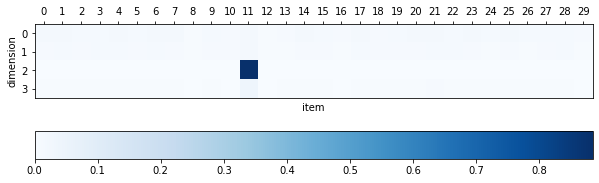

In [7]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


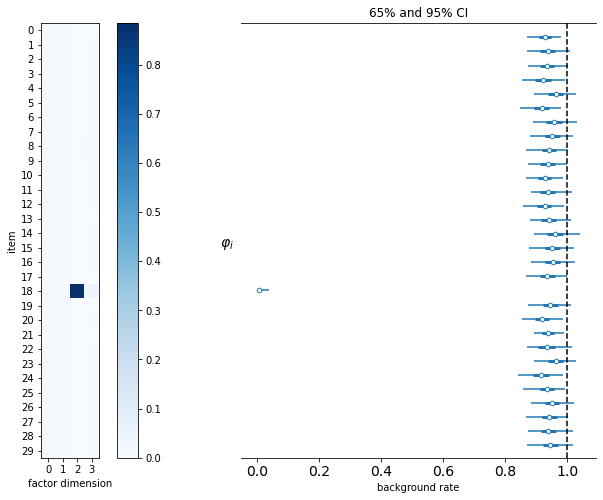

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
#plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

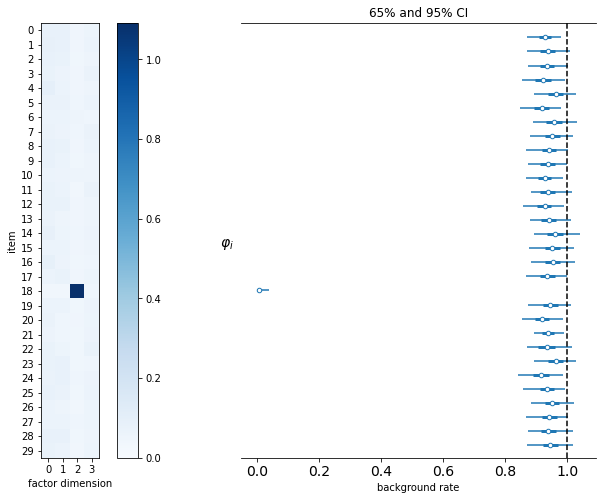

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.decoding_matrix().numpy().T[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.show()
